In [ ]:
pip install stop-words

In [ ]:
import pandas as pd
import numpy as np
import spacy
from stop_words import get_stop_words

import os     
import json
import re

import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import sklearn.preprocessing as pr
from sklearn.metrics import classification_report,confusion_matrix

In [39]:
from collections import Counter

In [71]:
file_path = './Musical_Instruments_5.json'
df= pd.read_json(file_path, lines=True)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [72]:
# Reclasificar las reviews: ahora 3 estrellas se consideran negativas
df["sentiment"] = df["overall"].apply(lambda x: 1 if x >= 4 else 0)
df= df[['reviewText', 'sentiment']]
df.dropna(subset=['reviewText', 'sentiment'], inplace=True)
df.head()

,reviewText,sentiment
0,"Not much to write about here, but it does exac...",1
1,The product does exactly as it should and is q...,1
2,The primary job of this device is to block the...,1
3,Nice windscreen protects my MXL mic and preven...,1
4,This pop filter is great. It looks and perform...,1


In [73]:
import nltk
from nltk.corpus import stopwords

# Descargar stopwords de NLTK 
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Función de limpieza básica
def clean_text(text):
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r"\d+", "", text)  # Eliminar números
    text = re.sub(r"[^\w\s]", "", text)  # Eliminar caracteres especiales
    return text

# Función para eliminar stopwords
def remove_stopwords(text):
    words = text.split()  # Tokenizar en palabras
    words = [word for word in words if word not in stop_words]  # Filtrar stopwords
    return " ".join(words)

# Aplicar cambios
df["reviewText"] = df["reviewText"].apply(clean_text).apply(remove_stopwords)


[nltk_data] Downloading package stopwords to C:\Users\Alejandro
[nltk_data]     Catalan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
# Guardar el df limpio
df.to_csv('df_games_limpio.csv', index=False)

# Cargar el df
#df = pd.read_csv('df_games_limpio.csv')

In [56]:
stop_words_ampliated = stop_words.union(set(['guitar']))

<function matplotlib.pyplot.show(close=None, block=None)>

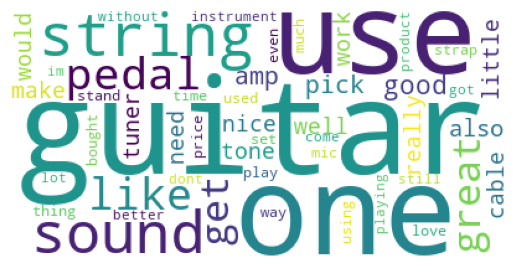

In [74]:
sentiment = 1
combined_text = " ".join(df.loc[df['sentiment'].isin([sentiment]), 'reviewText'])

wc = WordCloud(background_color='white', max_words=50, stopwords=stop_words)

plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show

In [75]:
sentences = df['reviewText'].values
labels = df['sentiment']
x_train, x_test, y_train, y_test = train_test_split(sentences, labels, test_size= 0.2, random_state=42, shuffle=True, stratify=labels)
print('Train instances:', len(x_train))
print('Train labels:', len(y_train))
print('Example:', y_train[0])
print('Test instances:', len(x_test))
print('Test labels:', len(y_test))
print('Example:', y_test[10])

Train instances: 8208
Train labels: 8208
Example: 1
Test instances: 2053
Test labels: 2053
Example: 1


In [76]:
label_counts = Counter(y_train)

print(f"Label: 0, Count: {label_counts.get(0)}")
print(f"Label: 1, Count: {label_counts.get(1)}")
print(f"Proportion: {label_counts.get(1)/label_counts.get(0)}")

label_counts = Counter(y_test)

print(f"Label: 0, Count: {label_counts.get(0)}")
print(f"Label: 1, Count: {label_counts.get(1)}")
print(f"Proportion: {label_counts.get(1)/label_counts.get(0)}")

Label: 0, Count: 991
Label: 1, Count: 7217
Proportion: 7.282542885973764
Label: 0, Count: 248
Label: 1, Count: 1805
Proportion: 7.278225806451613


In [80]:
features_extractors = [
    ["unigrams", CountVectorizer(ngram_range=(1, 1), lowercase=True, max_features=1000)],
    ["unigrams_v1", CountVectorizer(ngram_range=(1, 1),max_df=0.95, lowercase=True,max_features=1000)],
    ["bigrams", CountVectorizer(ngram_range=(2, 2), lowercase=True,max_features=1000)],
    ["trigrams", CountVectorizer(ngram_range=(3, 3), lowercase=True,max_features=1000)],
    ["tfidf", TfidfVectorizer(lowercase=True)]
]

estimators= [
    ['knn', KNeighborsClassifier(n_neighbors=5, n_jobs=2)],
    ['knn_v1', KNeighborsClassifier(n_neighbors=3, n_jobs=2)],
    ['bayes', GaussianNB()],
    ['rf', RandomForestClassifier(random_state=42, n_jobs=2)],
    ['svm', LinearSVC(random_state=42)]
]

In [81]:
results = {}
for feature_name, feature_model in features_extractors:
  print(f'Testing  {feature_name}')
  results[feature_name] = {}
  train_features = feature_model.fit_transform(x_train)
  test_features = feature_model.transform(x_test)

  if feature_name != 'tfidf':
    train_features = pr.normalize(train_features, axis=1)
    test_features = pr.normalize(test_features, axis=1)

  _x_train =train_features.toarray() if not isinstance(train_features, np.ndarray) else list(train_features)
  _x_test =test_features.toarray() if not isinstance(test_features, np.ndarray) else list(test_features)

  for estimator_name, estimator_model in estimators:
    print(f'\tTesting {estimator_name}')
    estimator_model.fit(_x_train, y_train)
    pred_labels = estimator_model.predict(_x_test)
    res = classification_report(y_test, pred_labels, output_dict=True)
    results[feature_name][estimator_name] = res
    del estimator_model
    print('\t\t\t', str(confusion_matrix(y_test, pred_labels)).replace('\n', '\n\t\t\t'))
    print('\t\t\t',classification_report(y_test, pred_labels).replace('\n', '\n\t\t\t'))

Testing  unigrams
	Testing knn
			 [[   0  248]
			 [   1 1804]]
			               precision    recall  f1-score   support
			
			           0       0.00      0.00      0.00       248
			           1       0.88      1.00      0.94      1805
			
			    accuracy                           0.88      2053
			   macro avg       0.44      0.50      0.47      2053
			weighted avg       0.77      0.88      0.82      2053
			
	Testing knn_v1
			 [[   0  248]
			 [   9 1796]]
			               precision    recall  f1-score   support
			
			           0       0.00      0.00      0.00       248
			           1       0.88      1.00      0.93      1805
			
			    accuracy                           0.87      2053
			   macro avg       0.44      0.50      0.47      2053
			weighted avg       0.77      0.87      0.82      2053
			
	Testing bayes
			 [[ 149   99]
			 [ 558 1247]]
			               precision    recall  f1-score   support
			
			           0       0.21      0.60      0.31       248
			    

c:\Users\Alejandro Catalan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alejandro Catalan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alejandro Catalan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

			 [[   0  248]
			 [   0 1805]]
			               precision    recall  f1-score   support
			
			           0       0.00      0.00      0.00       248
			           1       0.88      1.00      0.94      1805
			
			    accuracy                           0.88      2053
			   macro avg       0.44      0.50      0.47      2053
			weighted avg       0.77      0.88      0.82      2053
			
	Testing knn_v1


c:\Users\Alejandro Catalan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alejandro Catalan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alejandro Catalan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

			 [[   0  248]
			 [   0 1805]]
			               precision    recall  f1-score   support
			
			           0       0.00      0.00      0.00       248
			           1       0.88      1.00      0.94      1805
			
			    accuracy                           0.88      2053
			   macro avg       0.44      0.50      0.47      2053
			weighted avg       0.77      0.88      0.82      2053
			
	Testing bayes
			 [[  81  167]
			 [ 624 1181]]
			               precision    recall  f1-score   support
			
			           0       0.11      0.33      0.17       248
			           1       0.88      0.65      0.75      1805
			
			    accuracy                           0.61      2053
			   macro avg       0.50      0.49      0.46      2053
			weighted avg       0.78      0.61      0.68      2053
			
	Testing rf
			 [[   4  244]
			 [   0 1805]]
			               precision    recall  f1-score   support
			
			           0       1.00      0.02      0.03       248
			           1       0.88      1.00      

In [52]:
results

{'unigrams': {'knn': {'0': {'precision': 0.0,
    'recall': 0.0,
    'f1-score': 0.0,
    'support': 248.0},
   '1': {'precision': 0.8791423001949318,
    'recall': 0.9994459833795014,
    'f1-score': 0.9354420534093856,
    'support': 1805.0},
   'accuracy': 0.8787140769605456,
   'macro avg': {'precision': 0.4395711500974659,
    'recall': 0.4997229916897507,
    'f1-score': 0.4677210267046928,
    'support': 2053.0},
   'weighted avg': {'precision': 0.7729429380671466,
    'recall': 0.8787140769605456,
    'f1-score': 0.8224417469088849,
    'support': 2053.0}},
  'knn_v1': {'0': {'precision': 0.0,
    'recall': 0.0,
    'f1-score': 0.0,
    'support': 248.0},
   '1': {'precision': 0.8786692759295499,
    'recall': 0.9950138504155125,
    'f1-score': 0.933229410236425,
    'support': 1805.0},
   'accuracy': 0.8748173404773503,
   'macro avg': {'precision': 0.43933463796477495,
    'recall': 0.49750692520775625,
    'f1-score': 0.4666147051182125,
    'support': 2053.0},
   'weighted